In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


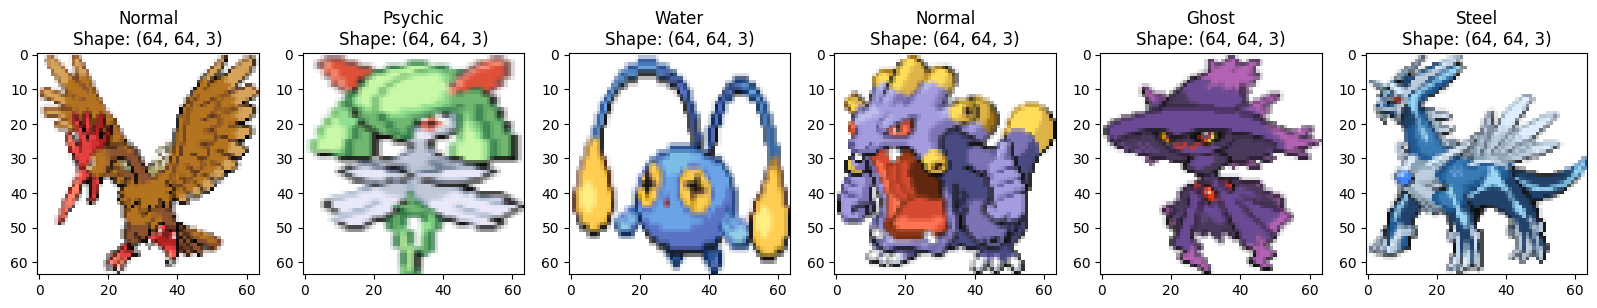

In [10]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [11]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1714433642.906990     921 service.cc:145] XLA service 0x759fbc0041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714433642.907025     921 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1714433643.322142     921 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1714433644.860392    1417 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1714433645.105225    1424 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1714433662.826891     921 device_compiler.h:188] Com

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - loss: 0.7283
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.2182
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1900
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1296
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0971
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0959
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1186
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1186
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1004
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0609
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0622
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0980
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1027
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1019
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1

Sampling sprite: 1000it [00:45, 22.01it/s]                        


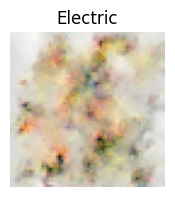

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 910ms/step - loss: 0.0770
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0536
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0574
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0939
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0775
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0569
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0622
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.1050
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1026
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0498
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0795
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0795
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0625
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0901
Epoch 34/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 22.96it/s]                        


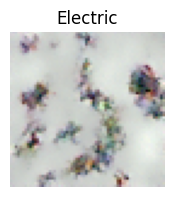

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - loss: 0.0567
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0653
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0848
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0479
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0532
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0498
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0594
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0844
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0529
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0577
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0721
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0466
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0362
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0352
Epoch 54/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 23.00it/s]                        


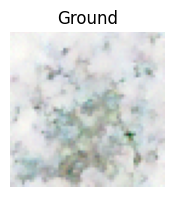

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - loss: 0.0948
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0596
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0796
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0458
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0856
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0480
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0603
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0803
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0587
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0704
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0815
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0608
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0470
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0456
Epoch 74/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:42, 23.73it/s]                        


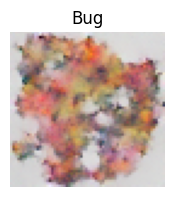

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 859ms/step - loss: 0.0473
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0342
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - loss: 0.0551
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 0.0568
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - loss: 0.0515
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0861
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.0572
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0587
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0457
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0388
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0651
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0739
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0616
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0625
Epoch 94/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:46, 21.46it/s]                        


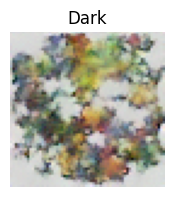

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - loss: 0.0406


In [12]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

In [13]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0670
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0557
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0499
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0676
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0607
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0395
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0552
Epoch 8/500
 2/63 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 0.0137

Generating sample 1/6


Sampling sprite: 500it [00:21, 23.60it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:20, 23.89it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:20, 24.11it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:20, 24.07it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:20, 24.20it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:20, 24.15it/s]                         


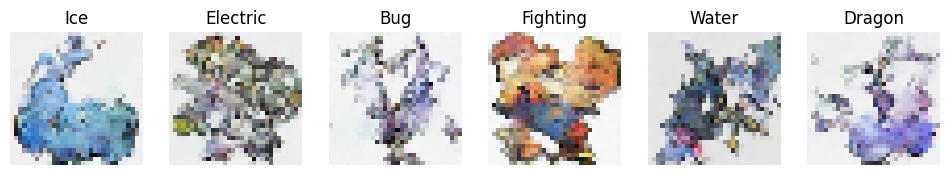

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.49it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.50it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.75it/s]                         


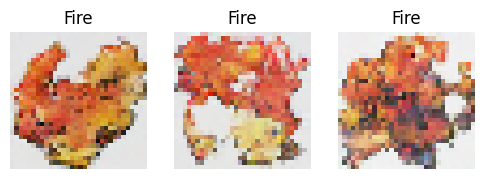

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.59it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.87it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.77it/s]                         


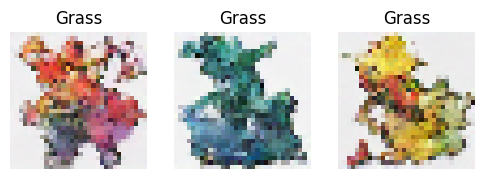

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.50it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.53it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.61it/s]                         


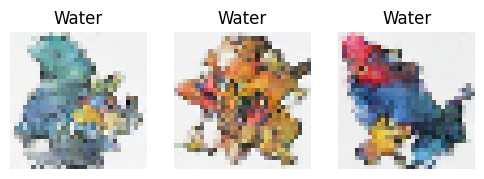

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

Generating sample 1/6


Sampling sprite: 500it [00:19, 25.05it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:19, 25.14it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:19, 25.21it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:20, 24.61it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:20, 24.94it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:20, 24.94it/s]                         


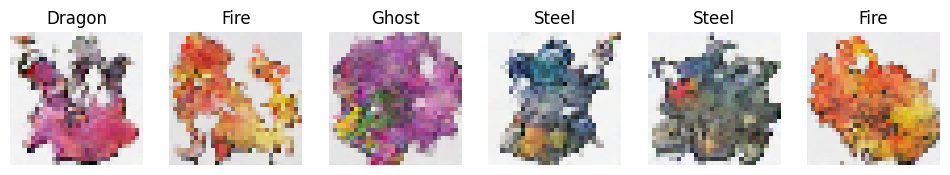

Generating sample 1/6


Sampling sprite: 500it [00:19, 25.05it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:19, 25.12it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:19, 25.33it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:19, 25.36it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:19, 25.34it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:19, 25.28it/s]                         


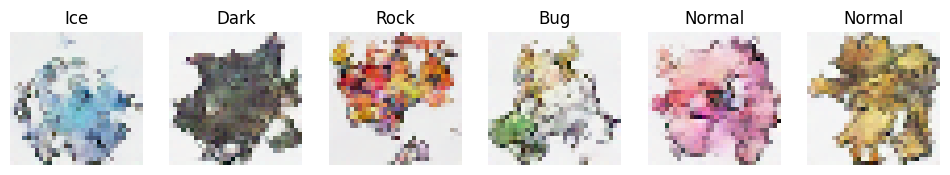

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

Model diffusion_32_128_600_500_linear_ddpm, saved successfully!


In [40]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)